1. Import Dependencies & Modules

In [1]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import config

from src.model_training import (
    train_anomaly_detector,
    prepare_features_targets,
    train_and_tune_rf,
    evaluate_model,
    plot_results
)
from src.data_processing import extract_molecular_data, process_molecular_csv

sns.set(style="whitegrid")

INFO: Enabling RDKit 2024.09.2 jupyter extensions


2. Data Processing

In [2]:
raw_dir = os.path.join(config.RAW_DATA_DIR, "PhotochemCAD", "Common Compounds")
processed_dir = config.PROCESSED_DATA_DIR
os.makedirs(processed_dir, exist_ok=True)

molecular_csv = config.MOLECULAR_DATA_CSV
train_csv = config.TRAIN_DATA_CSV
test_csv = config.TEST_DATA_CSV

# Step 1: Extract data from raw files to generate molecular_data.csv
extract_molecular_data(raw_dir, molecular_csv, max_peaks=config.MAX_PEAKS)

# Step 2: Process molecular_data.csv to generate training and test CSVs
process_molecular_csv(molecular_csv, train_csv, test_csv)

Extracting molecular data: 100%|██████████| 338/338 [03:41<00:00,  1.53file/s]
INFO: Detected 1 outliers in Absorption Maxima
INFO: Value range: [1.00, 1.00]
INFO: 294/338 molecules successfully processed.
[18:57:12] WARNING: not removing hydrogen atom without neighbors
[18:57:12] WARNING: not removing hydrogen atom without neighbors
[18:57:12] WARNING: not removing hydrogen atom without neighbors
INFO: Total outliers in dataset: 0
INFO: Outliers in training set: 0
INFO: Outliers in test set: 0


3. Load Training & Test Data

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (235, 4)
Test data shape: (59, 4)


4. Prepare Features and Targets

In [4]:
X_train, X_test, y_train, y_test, train_df, test_df = prepare_features_targets(train_df, test_df)
print("Features prepared:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

INFO: X_train shape: (235, 1024), X_test shape: (59, 1024)


Features prepared:
X_train shape: (235, 1024)
X_test shape: (59, 1024)


5. Train the Model

In [5]:
# Train anomaly detector
anomaly_detector = train_anomaly_detector(X_train)

# Train main model
best_model = train_and_tune_rf(X_train, y_train, optimization_method="final")

INFO: Using pre-optimized parameters for final model


6. Evaluate the Model

In [6]:
y_pred, pred_outliers, anomalies, stat_outliers = evaluate_model(
    best_model, X_test, y_test, anomaly_detector=anomaly_detector, test_df=test_df
)

PERFORMANCE REPORT

OVERALL METRICS
MSE (wavelength): 7429.1674 nm²
R²: 0.6810
MAE (energy): 0.5454 eV

METRICS (EXCLUDING PREDICTION OUTLIERS)
MSE (wavelength): 5080.7349 nm²
R²: 0.7789
MAE (energy): 0.4862 eV

OUTLIER ANALYSIS
Total samples: 59
Prediction outliers: 3 (5.1%)
Anomalies detected: 6 (10.2%)
Overlap (pred/anom): 1 samples
Statistical outliers: 0 (0.0%)
Overlap (pred/stat): 0 samples
Overlap (anom/stat): 0 samples
Agreement across all methods: 0 samples

ERROR ANALYSIS
Mean absolute error: 60.9271 nm
Error std dev: 60.9677 nm
Max error: 250.0205 nm
Median error: 39.5578 nm

OUTLIER METRICS
MSE (wavelength): 51266.5753 nm²
R²: -1.2842
MAE (energy): 1.6502 eV


7. Visualize the Results

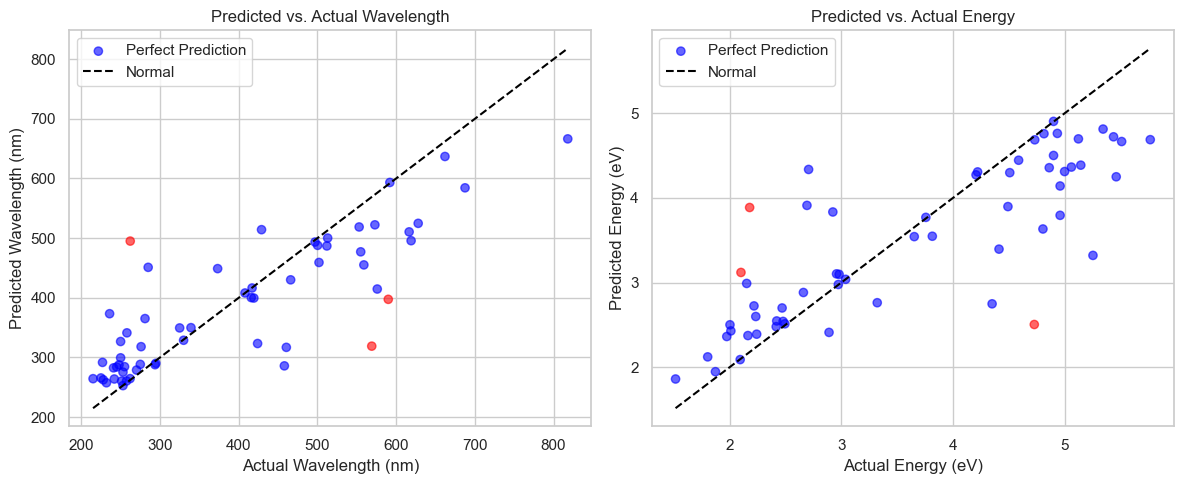

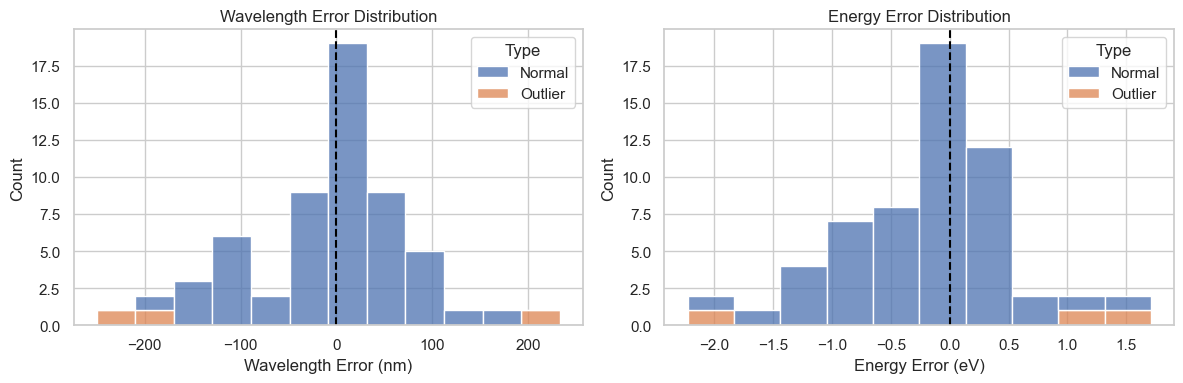

In [7]:
plot_results(y_test, y_pred, pred_outliers)